In [1]:
import numpy as np
import keras
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Dropout
from keras_contrib.layers.crf import CRF
import matplotlib.pyplot as plt
import os
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau
import json
from keras import metrics
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

Using TensorFlow backend.


In [2]:
sample_x = []
sample_y = []
vocabs = {'UNK'}
datas = []
for line in open('/home/wcb/nerXY/train_data/2.1_train.txt', 'r', encoding='utf-8'):
    line = line.rstrip().split('\t')
    if not line:
        continue
    char = line[0]
    if not char:
        continue
    cate = line[-1]
    sample_x.append(char)
    sample_y.append(cate)
    vocabs.add(char)
    if char in ['.', '?', '!']:
        datas.append([sample_x, sample_y])
        sample_x = []
        sample_y = []
word_dict = {wd:index for index,wd in enumerate(list(vocabs))}

In [3]:
file = open('/home/wcb/nerXY/word_dict/2.1_word_dict.txt', 'w') 
for k,v in word_dict.items():
    file.write(str(v) + ' ' + str(k) + '\n')
file.close()

In [4]:
class_dict = {'O':0,
              'I-MINERAL':1,
              'I-ROCK':2,
              'I-ELEMENT':3
             }
x_train = [[word_dict[char] for char in data[0]] for data in datas]
y_train = [[class_dict[label] for label in data[1]] for data in datas]
x_train = pad_sequences(x_train, maxlen=40, padding='post')
y = pad_sequences(y_train, maxlen=40, padding='post')
y_train = np.expand_dims(y, axis=2)

In [5]:
embeddings_dict = {}
with open('/home/wcb/nerXY/w2v/2.1_w2v.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.strip().split(' ')
        if len(values) < 68:
            continue
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_dict[word] = coefs
print('Found %s word vectors.' % len(embeddings_dict))

embedding_matrix = np.zeros((len(word_dict) + 1, 68))
for word, i in word_dict.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Found 2979 word vectors.


In [6]:
model = Sequential()
embedding_layer = Embedding(len(word_dict) + 1,
                            68,
                            weights=[embedding_matrix],
                            input_length=40,
                            trainable=False,
                            mask_zero=True)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(8, return_sequences=True,  activation='softsign')))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(len(class_dict))))
crf_layer = CRF(len(class_dict), sparse_target=True)
model.add(crf_layer)
model.compile(optimizer='AdaGrad', loss=crf_layer.loss_function, metrics=[crf_layer.accuracy])
model.summary()










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



/Users/yvse/opt/anaconda3/envs/keras/lib/python3.7/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/Users/yvse/opt/anaconda3/envs/keras/lib/python3.7/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 68)            202708    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40, 16)            4928      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 16)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 4)             68        
_________________________________________________________________
crf_1 (CRF)                  (None, 40, 4)             44        
Total params: 207,748
Trainable params: 5,040
Non-trainable params: 202,708
_________________________________________________________________


In [7]:
history = model.fit(x_train[:], y_train[:], validation_split=0.10, batch_size=64, epochs=1000)



Train on 1602 samples, validate on 178 samples
Epoch 1/1000
1602/1602 [==============================] - 2s 1ms/step - loss: 2.3959 - crf_viterbi_accuracy: 0.8514 - val_loss: 2.4893 - val_crf_viterbi_accuracy: 0.8590
Epoch 2/1000
1602/1602 [==============================] - 1s 555us/step - loss: 2.3102 - crf_viterbi_accuracy: 0.8757 - val_loss: 2.4638 - val_crf_viterbi_accuracy: 0.8590
Epoch 3/1000
1602/1602 [==============================] - 1s 563us/step - loss: 2.2922 - crf_viterbi_accuracy: 0.8757 - val_loss: 2.4441 - val_crf_viterbi_accuracy: 0.8590
Epoch 4/1000
1602/1602 [==============================] - 1s 635us/step - loss: 2.2774 - crf_viterbi_accuracy: 0.8759 - val_loss: 2.4300 - val_crf_viterbi_accuracy: 0.8590
Epoch 5/1000
1602/1602 [==============================] - 1s 601us/step - loss: 2.2690 - crf_viterbi_accuracy: 0.8757 - val_loss: 2.4195 - val_crf_viterbi_accuracy: 0.8590
Epoch 6/1000
1602/1602 [==============================] - 1s 581us/step - loss: 2.2594 - crf_

Epoch 46/1000
1602/1602 [==============================] - 1s 545us/step - loss: 2.0973 - crf_viterbi_accuracy: 0.8905 - val_loss: 2.2381 - val_crf_viterbi_accuracy: 0.8853
Epoch 47/1000
1602/1602 [==============================] - 1s 537us/step - loss: 2.0929 - crf_viterbi_accuracy: 0.8914 - val_loss: 2.2354 - val_crf_viterbi_accuracy: 0.8869
Epoch 48/1000
1602/1602 [==============================] - 1s 538us/step - loss: 2.0927 - crf_viterbi_accuracy: 0.8906 - val_loss: 2.2330 - val_crf_viterbi_accuracy: 0.8880
Epoch 49/1000
1602/1602 [==============================] - 1s 540us/step - loss: 2.0906 - crf_viterbi_accuracy: 0.8929 - val_loss: 2.2295 - val_crf_viterbi_accuracy: 0.8906
Epoch 50/1000
1602/1602 [==============================] - 1s 537us/step - loss: 2.0901 - crf_viterbi_accuracy: 0.8940 - val_loss: 2.2269 - val_crf_viterbi_accuracy: 0.8935
Epoch 51/1000
1602/1602 [==============================] - 1s 539us/step - loss: 2.0875 - crf_viterbi_accuracy: 0.8927 - val_loss: 2.22

1602/1602 [==============================] - 1s 538us/step - loss: 1.9916 - crf_viterbi_accuracy: 0.9236 - val_loss: 2.1072 - val_crf_viterbi_accuracy: 0.9329
Epoch 141/1000
1602/1602 [==============================] - 1s 539us/step - loss: 1.9897 - crf_viterbi_accuracy: 0.9229 - val_loss: 2.1074 - val_crf_viterbi_accuracy: 0.9332
Epoch 142/1000
1602/1602 [==============================] - 1s 534us/step - loss: 1.9950 - crf_viterbi_accuracy: 0.9227 - val_loss: 2.1061 - val_crf_viterbi_accuracy: 0.9332
Epoch 143/1000
1602/1602 [==============================] - 1s 534us/step - loss: 1.9918 - crf_viterbi_accuracy: 0.9223 - val_loss: 2.1039 - val_crf_viterbi_accuracy: 0.9328
Epoch 144/1000
1602/1602 [==============================] - 1s 535us/step - loss: 1.9910 - crf_viterbi_accuracy: 0.9229 - val_loss: 2.1030 - val_crf_viterbi_accuracy: 0.9334
Epoch 145/1000
1602/1602 [==============================] - 1s 533us/step - loss: 1.9877 - crf_viterbi_accuracy: 0.9251 - val_loss: 2.1027 - val_

1602/1602 [==============================] - 1s 572us/step - loss: 1.9525 - crf_viterbi_accuracy: 0.9353 - val_loss: 2.0608 - val_crf_viterbi_accuracy: 0.9443
Epoch 235/1000
1602/1602 [==============================] - 1s 571us/step - loss: 1.9527 - crf_viterbi_accuracy: 0.9360 - val_loss: 2.0604 - val_crf_viterbi_accuracy: 0.9461
Epoch 236/1000
1602/1602 [==============================] - 1s 571us/step - loss: 1.9535 - crf_viterbi_accuracy: 0.9346 - val_loss: 2.0601 - val_crf_viterbi_accuracy: 0.9449
Epoch 237/1000
1602/1602 [==============================] - 1s 570us/step - loss: 1.9537 - crf_viterbi_accuracy: 0.9344 - val_loss: 2.0597 - val_crf_viterbi_accuracy: 0.9446
Epoch 238/1000
1602/1602 [==============================] - 1s 571us/step - loss: 1.9513 - crf_viterbi_accuracy: 0.9359 - val_loss: 2.0598 - val_crf_viterbi_accuracy: 0.9443
Epoch 239/1000
1602/1602 [==============================] - 1s 569us/step - loss: 1.9541 - crf_viterbi_accuracy: 0.9338 - val_loss: 2.0589 - val_

1602/1602 [==============================] - 1s 593us/step - loss: 1.9316 - crf_viterbi_accuracy: 0.9417 - val_loss: 2.0390 - val_crf_viterbi_accuracy: 0.9498
Epoch 329/1000
1602/1602 [==============================] - 1s 587us/step - loss: 1.9309 - crf_viterbi_accuracy: 0.9422 - val_loss: 2.0387 - val_crf_viterbi_accuracy: 0.9498
Epoch 330/1000
1602/1602 [==============================] - 1s 593us/step - loss: 1.9348 - crf_viterbi_accuracy: 0.9418 - val_loss: 2.0390 - val_crf_viterbi_accuracy: 0.9495
Epoch 331/1000
1602/1602 [==============================] - 1s 570us/step - loss: 1.9311 - crf_viterbi_accuracy: 0.9416 - val_loss: 2.0384 - val_crf_viterbi_accuracy: 0.9498
Epoch 332/1000
1602/1602 [==============================] - 1s 569us/step - loss: 1.9294 - crf_viterbi_accuracy: 0.9401 - val_loss: 2.0383 - val_crf_viterbi_accuracy: 0.9498
Epoch 333/1000
1602/1602 [==============================] - 1s 578us/step - loss: 1.9326 - crf_viterbi_accuracy: 0.9402 - val_loss: 2.0381 - val_

1602/1602 [==============================] - 1s 593us/step - loss: 1.9206 - crf_viterbi_accuracy: 0.9448 - val_loss: 2.0246 - val_crf_viterbi_accuracy: 0.9524
Epoch 423/1000
1602/1602 [==============================] - 1s 590us/step - loss: 1.9181 - crf_viterbi_accuracy: 0.9460 - val_loss: 2.0245 - val_crf_viterbi_accuracy: 0.9529
Epoch 424/1000
1602/1602 [==============================] - 1s 589us/step - loss: 1.9199 - crf_viterbi_accuracy: 0.9462 - val_loss: 2.0242 - val_crf_viterbi_accuracy: 0.9526
Epoch 425/1000
1602/1602 [==============================] - 1s 582us/step - loss: 1.9224 - crf_viterbi_accuracy: 0.9442 - val_loss: 2.0244 - val_crf_viterbi_accuracy: 0.9524
Epoch 426/1000
1602/1602 [==============================] - 1s 579us/step - loss: 1.9208 - crf_viterbi_accuracy: 0.9442 - val_loss: 2.0239 - val_crf_viterbi_accuracy: 0.9529
Epoch 427/1000
1602/1602 [==============================] - 1s 571us/step - loss: 1.9217 - crf_viterbi_accuracy: 0.9448 - val_loss: 2.0237 - val_

1602/1602 [==============================] - 1s 624us/step - loss: 1.9105 - crf_viterbi_accuracy: 0.9478 - val_loss: 2.0147 - val_crf_viterbi_accuracy: 0.9555
Epoch 517/1000
1602/1602 [==============================] - 1s 613us/step - loss: 1.9074 - crf_viterbi_accuracy: 0.9494 - val_loss: 2.0146 - val_crf_viterbi_accuracy: 0.9557
Epoch 518/1000
1602/1602 [==============================] - 1s 638us/step - loss: 1.9107 - crf_viterbi_accuracy: 0.9456 - val_loss: 2.0148 - val_crf_viterbi_accuracy: 0.9552
Epoch 519/1000
1602/1602 [==============================] - 1s 624us/step - loss: 1.9117 - crf_viterbi_accuracy: 0.9469 - val_loss: 2.0143 - val_crf_viterbi_accuracy: 0.9554
Epoch 520/1000
1602/1602 [==============================] - 1s 625us/step - loss: 1.9095 - crf_viterbi_accuracy: 0.9478 - val_loss: 2.0142 - val_crf_viterbi_accuracy: 0.9557
Epoch 521/1000
1602/1602 [==============================] - 1s 641us/step - loss: 1.9080 - crf_viterbi_accuracy: 0.9485 - val_loss: 2.0140 - val_

1602/1602 [==============================] - 1s 588us/step - loss: 1.9016 - crf_viterbi_accuracy: 0.9505 - val_loss: 2.0074 - val_crf_viterbi_accuracy: 0.9593
Epoch 611/1000
1602/1602 [==============================] - 1s 579us/step - loss: 1.9026 - crf_viterbi_accuracy: 0.9490 - val_loss: 2.0077 - val_crf_viterbi_accuracy: 0.9593
Epoch 612/1000
1602/1602 [==============================] - 1s 577us/step - loss: 1.9040 - crf_viterbi_accuracy: 0.9494 - val_loss: 2.0081 - val_crf_viterbi_accuracy: 0.9577
Epoch 613/1000
1602/1602 [==============================] - 1s 577us/step - loss: 1.9037 - crf_viterbi_accuracy: 0.9496 - val_loss: 2.0078 - val_crf_viterbi_accuracy: 0.9583
Epoch 614/1000
1602/1602 [==============================] - 1s 574us/step - loss: 1.9042 - crf_viterbi_accuracy: 0.9493 - val_loss: 2.0073 - val_crf_viterbi_accuracy: 0.9596
Epoch 615/1000
1602/1602 [==============================] - 1s 578us/step - loss: 1.9018 - crf_viterbi_accuracy: 0.9502 - val_loss: 2.0076 - val_

1602/1602 [==============================] - 1s 562us/step - loss: 1.8956 - crf_viterbi_accuracy: 0.9524 - val_loss: 2.0009 - val_crf_viterbi_accuracy: 0.9617
Epoch 705/1000
1602/1602 [==============================] - 1s 570us/step - loss: 1.8971 - crf_viterbi_accuracy: 0.9529 - val_loss: 2.0009 - val_crf_viterbi_accuracy: 0.9617
Epoch 706/1000
1602/1602 [==============================] - 1s 579us/step - loss: 1.8984 - crf_viterbi_accuracy: 0.9519 - val_loss: 2.0008 - val_crf_viterbi_accuracy: 0.9617
Epoch 707/1000
1602/1602 [==============================] - 1s 568us/step - loss: 1.8980 - crf_viterbi_accuracy: 0.9503 - val_loss: 2.0003 - val_crf_viterbi_accuracy: 0.9614
Epoch 708/1000
1602/1602 [==============================] - 1s 573us/step - loss: 1.8968 - crf_viterbi_accuracy: 0.9515 - val_loss: 2.0005 - val_crf_viterbi_accuracy: 0.9614
Epoch 709/1000
1602/1602 [==============================] - 1s 592us/step - loss: 1.8976 - crf_viterbi_accuracy: 0.9521 - val_loss: 2.0007 - val_

1602/1602 [==============================] - 1s 666us/step - loss: 1.8934 - crf_viterbi_accuracy: 0.9533 - val_loss: 1.9959 - val_crf_viterbi_accuracy: 0.9619
Epoch 799/1000
1602/1602 [==============================] - 1s 670us/step - loss: 1.8945 - crf_viterbi_accuracy: 0.9528 - val_loss: 1.9959 - val_crf_viterbi_accuracy: 0.9619
Epoch 800/1000
1602/1602 [==============================] - 1s 647us/step - loss: 1.8941 - crf_viterbi_accuracy: 0.9518 - val_loss: 1.9962 - val_crf_viterbi_accuracy: 0.9619
Epoch 801/1000
1602/1602 [==============================] - 1s 634us/step - loss: 1.8929 - crf_viterbi_accuracy: 0.9531 - val_loss: 1.9962 - val_crf_viterbi_accuracy: 0.9614
Epoch 802/1000
1602/1602 [==============================] - 1s 656us/step - loss: 1.8913 - crf_viterbi_accuracy: 0.9534 - val_loss: 1.9963 - val_crf_viterbi_accuracy: 0.9614
Epoch 803/1000
1602/1602 [==============================] - 1s 706us/step - loss: 1.8945 - crf_viterbi_accuracy: 0.9524 - val_loss: 1.9962 - val_

1602/1602 [==============================] - 1s 591us/step - loss: 1.8867 - crf_viterbi_accuracy: 0.9547 - val_loss: 1.9923 - val_crf_viterbi_accuracy: 0.9624
Epoch 893/1000
1602/1602 [==============================] - 1s 579us/step - loss: 1.8878 - crf_viterbi_accuracy: 0.9540 - val_loss: 1.9923 - val_crf_viterbi_accuracy: 0.9622
Epoch 894/1000
1602/1602 [==============================] - 1s 584us/step - loss: 1.8881 - crf_viterbi_accuracy: 0.9541 - val_loss: 1.9921 - val_crf_viterbi_accuracy: 0.9622
Epoch 895/1000
1602/1602 [==============================] - 1s 578us/step - loss: 1.8900 - crf_viterbi_accuracy: 0.9535 - val_loss: 1.9920 - val_crf_viterbi_accuracy: 0.9622
Epoch 896/1000
1602/1602 [==============================] - 1s 578us/step - loss: 1.8904 - crf_viterbi_accuracy: 0.9536 - val_loss: 1.9918 - val_crf_viterbi_accuracy: 0.9622
Epoch 897/1000
1602/1602 [==============================] - 1s 585us/step - loss: 1.8874 - crf_viterbi_accuracy: 0.9545 - val_loss: 1.9918 - val_

1602/1602 [==============================] - 1s 581us/step - loss: 1.8847 - crf_viterbi_accuracy: 0.9563 - val_loss: 1.9885 - val_crf_viterbi_accuracy: 0.9640
Epoch 987/1000
1602/1602 [==============================] - 1s 576us/step - loss: 1.8862 - crf_viterbi_accuracy: 0.9559 - val_loss: 1.9887 - val_crf_viterbi_accuracy: 0.9638
Epoch 988/1000
1602/1602 [==============================] - 1s 576us/step - loss: 1.8860 - crf_viterbi_accuracy: 0.9549 - val_loss: 1.9885 - val_crf_viterbi_accuracy: 0.9638
Epoch 989/1000
1602/1602 [==============================] - 1s 574us/step - loss: 1.8885 - crf_viterbi_accuracy: 0.9545 - val_loss: 1.9886 - val_crf_viterbi_accuracy: 0.9640
Epoch 990/1000
1602/1602 [==============================] - 1s 570us/step - loss: 1.8847 - crf_viterbi_accuracy: 0.9553 - val_loss: 1.9883 - val_crf_viterbi_accuracy: 0.9640
Epoch 991/1000
1602/1602 [==============================] - 1s 589us/step - loss: 1.8826 - crf_viterbi_accuracy: 0.9557 - val_loss: 1.9883 - val_

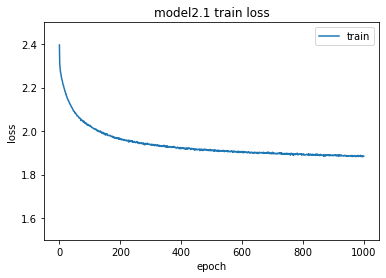

In [10]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.title('model2.1 train loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train'], loc='upper right')
pyplot.ylim([1.5,2.5])

In [13]:
model.save('/home/wcb/nerXY/model/model2.1.h5')